In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = './drive/MyDrive/BIOE484FP/'

Mounted at /content/drive


In [ ]:
t2_path = data_dir + 'IXI516-HH-2297-DE3Diso_-s3T223_-0401-00004-000002-02.nii'
t1_path = data_dir + 'IXI516-HH-2297-MADisoTFE1_-s3T223_-0301-00003-000001-01.nii'


t2_img = nib.load(t2_path)
t1_img = nib.load(t1_path)


t2_data = t2_img.get_fdata()
t1_data = t1_img.get_fdata()


print("T2 shape:", t2_data.shape)
print("T1 shape:", t1_data.shape)

T2 shape: (256, 256, 130)
T1 shape: (256, 256, 150)


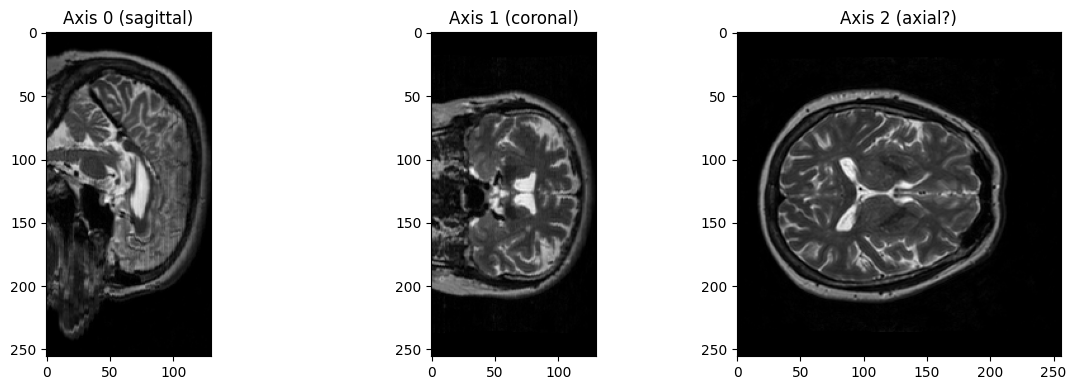

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(t2_data[t2_data.shape[0] // 2, :, :], cmap='gray')
axs[0].set_title('Axis 0 (sagittal)')

axs[1].imshow(t2_data[:, t2_data.shape[1] // 2, :], cmap='gray')
axs[1].set_title('Axis 1 (coronal)')

axs[2].imshow(t2_data[:, :, t2_data.shape[2] // 2], cmap='gray')
axs[2].set_title('Axis 2 (axial?)')

plt.tight_layout()
plt.show()

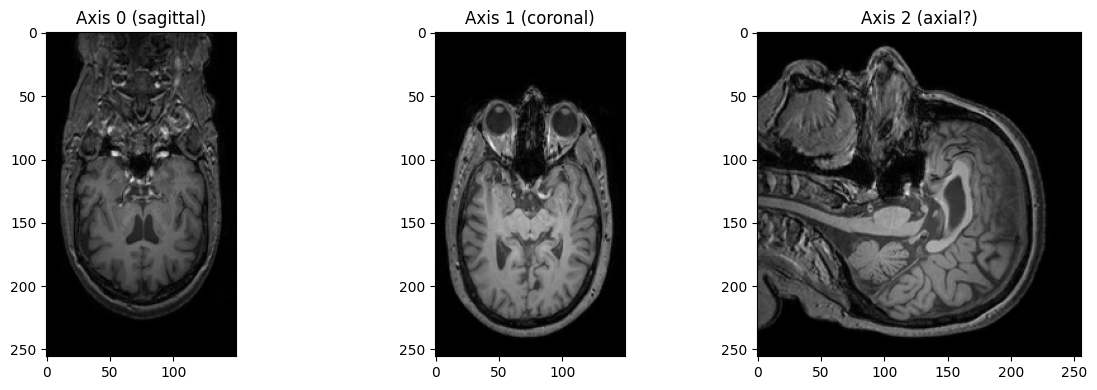

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(t1_data[t1_data.shape[0] // 2, :, :], cmap='gray')
axs[0].set_title('Axis 0 (sagittal)')

axs[1].imshow(t1_data[:, t1_data.shape[1] // 2, :], cmap='gray')
axs[1].set_title('Axis 1 (coronal)')

axs[2].imshow(t1_data[:, :, t1_data.shape[2] // 2], cmap='gray')
axs[2].set_title('Axis 2 (axial?)')

plt.tight_layout()
plt.show()

In [ ]:

t2_slice_idx = 70
t2_aff = t2_img.affine
t1_aff = t1_img.affine


t2_voxel = np.array([t2_data.shape[0]//2, t2_data.shape[1]//2, t2_slice_idx, 1])
t2_world = t2_aff @ t2_voxel  # Gives (x, y, z, 1)
t2_z_mm = t2_world[2]


t1_voxel = np.linalg.inv(t1_aff) @ t2_world
t1_slice_idx = int(round(t1_voxel[1]))

print("Matching T1 slice index:", t1_slice_idx)

Matching T1 slice index: 151


In [ ]:
t2_slice = t2_data[:,:, t2_slice_idx]

t1_slice_idx = 151
t1_slice = t1_data[:, t1_slice_idx, :]

t1_slice = np.rot90(t1_slice)
t1_slice = np.fliplr(t1_slice)

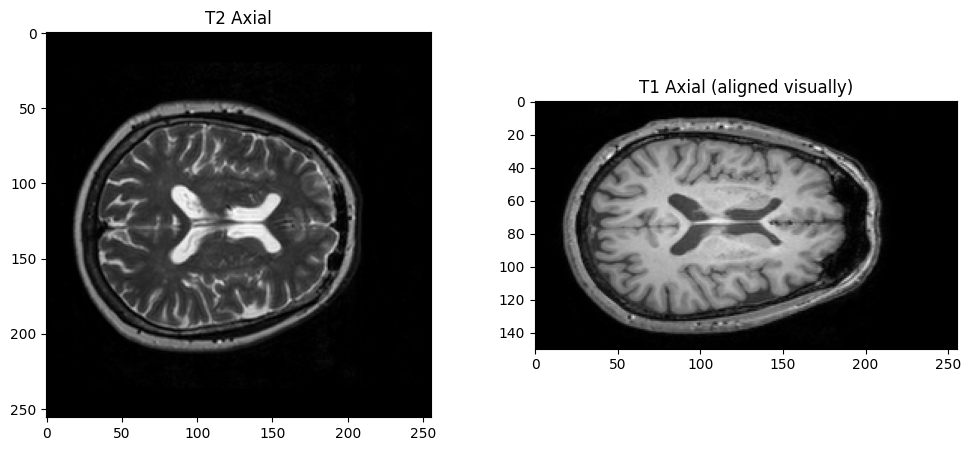

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(t2_slice, cmap='gray')
plt.title('T2 Axial')

plt.subplot(1, 2, 2)
plt.imshow(t1_slice, cmap='gray')
plt.title('T1 Axial (aligned visually)')
plt.show()

In [ ]:
print("T2 slice shape:", t2_slice.shape)
print("T1 slice shape:", t1_slice.shape)

T2 slice shape: (256, 256)
T1 slice shape: (150, 256)


# Keypoint-Based

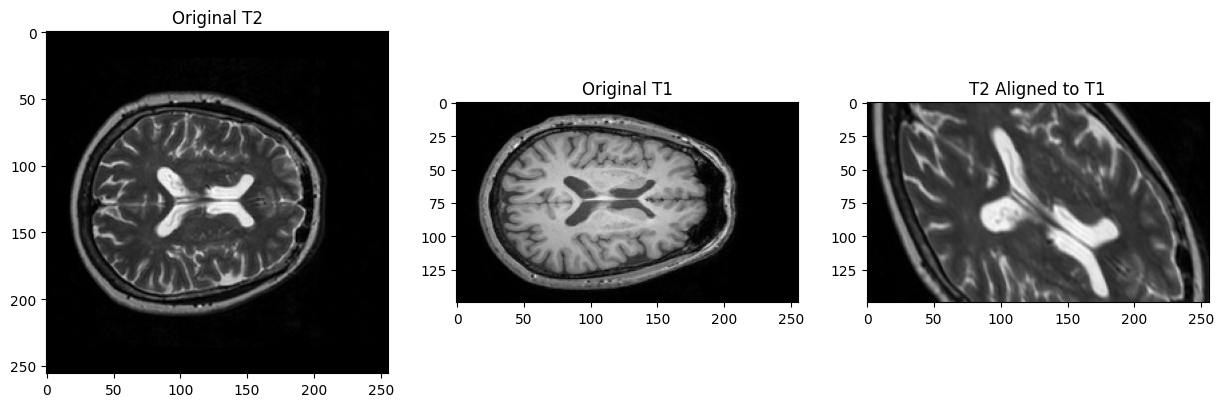

In [ ]:
import cv2
from skimage.transform import warp
from skimage.transform import AffineTransform
from skimage.color import rgb2gray

t2_slice_uint8 = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
t1_slice_uint8 = cv2.normalize(t1_slice, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

orb = cv2.ORB_create(nfeatures=500)

kp1, des1 = orb.detectAndCompute(t2_slice_uint8, None)
kp2, des2 = orb.detectAndCompute(t1_slice_uint8, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key=lambda x: x.distance)

src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

model_robust, inliers = cv2.estimateAffine2D(src_pts, dst_pts)

t2_aligned = cv2.warpAffine(t2_slice, model_robust, (t1_slice.shape[1], t1_slice.shape[0]))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(t2_slice, cmap='gray')
plt.title("Original T2")

plt.subplot(1, 3, 2)
plt.imshow(t1_slice, cmap='gray')
plt.title("Original T1")

plt.subplot(1, 3, 3)
plt.imshow(t2_aligned, cmap='gray')
plt.title("T2 Aligned to T1")
plt.show()


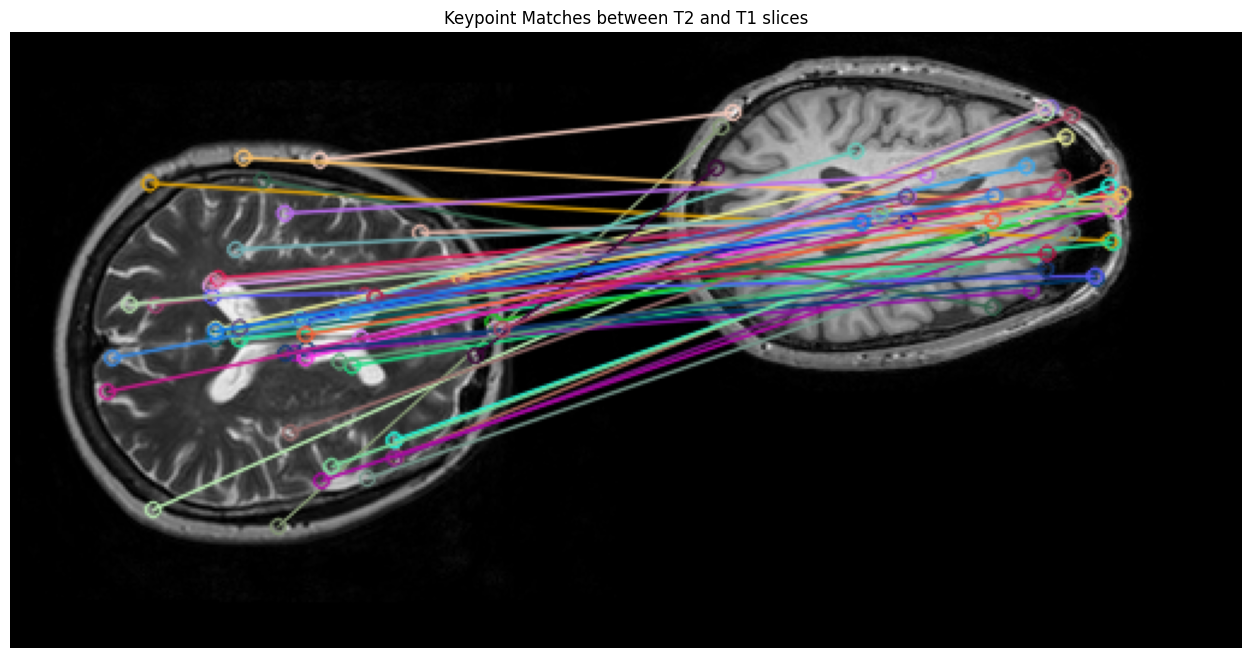

In [ ]:
orb = cv2.ORB_create(nfeatures=500)
kp1, des1 = orb.detectAndCompute(t2_slice_uint8, None)
kp2, des2 = orb.detectAndCompute(t1_slice_uint8, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(
    t2_slice_uint8, kp1,
    t1_slice_uint8, kp2,
    matches[:50], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(img_matches, cmap='gray')
plt.title("Keypoint Matches between T2 and T1 slices")
plt.axis('off')
plt.show()


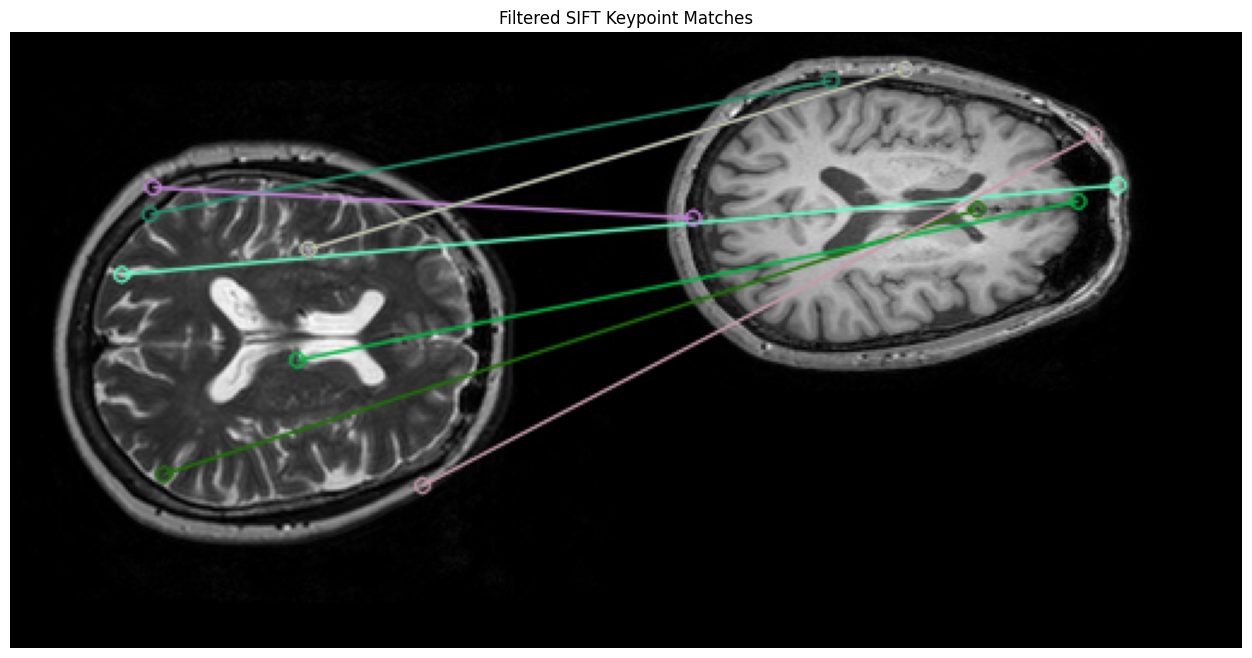

In [ ]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(t2_slice_uint8, None)
kp2, des2 = sift.detectAndCompute(t1_slice_uint8, None)

index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

img_matches = cv2.drawMatches(
    t2_slice_uint8, kp1,
    t1_slice_uint8, kp2,
    good_matches[:50], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(img_matches)
plt.title("Filtered SIFT Keypoint Matches")
plt.axis('off')
plt.show()


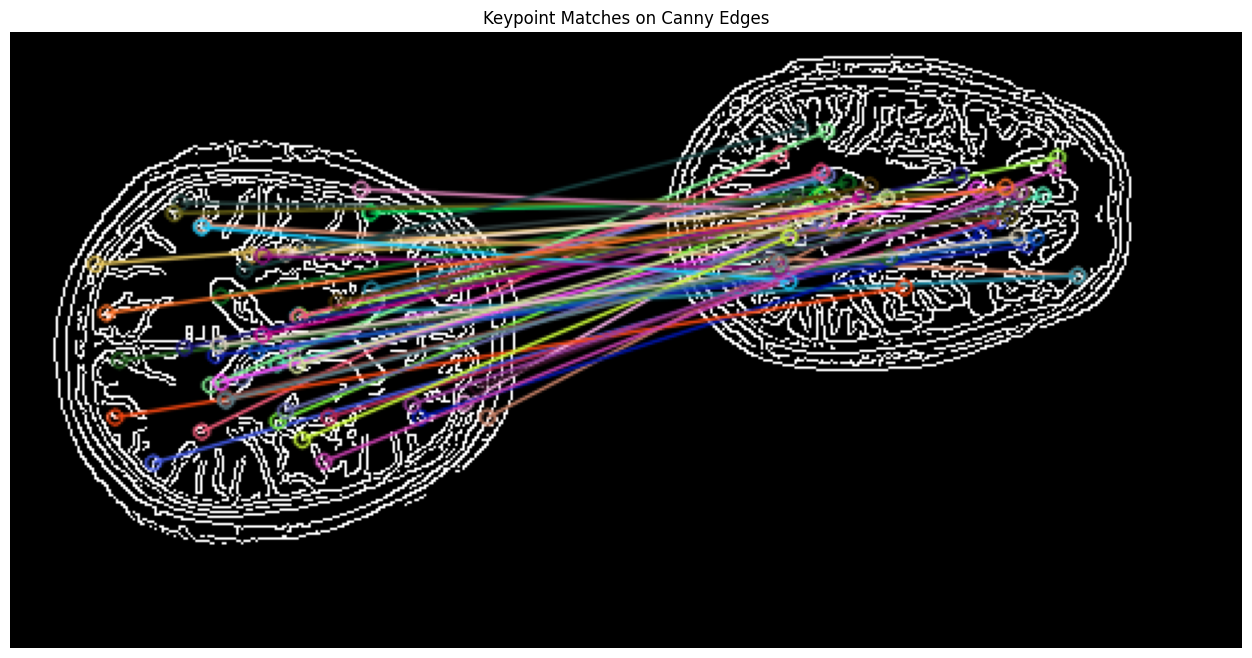

In [ ]:
t2_edges = cv2.Canny(t2_slice_uint8, 50, 150)
t1_edges = cv2.Canny(t1_slice_uint8, 50, 150)

orb = cv2.ORB_create(nfeatures=500)
kp1, des1 = orb.detectAndCompute(t2_edges, None)
kp2, des2 = orb.detectAndCompute(t1_edges, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(
    t2_edges, kp1,
    t1_edges, kp2,
    matches[:50], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(img_matches, cmap='gray')
plt.title("Keypoint Matches on Canny Edges")
plt.axis('off')
plt.show()


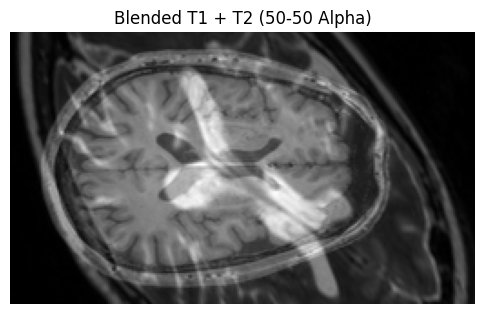

In [ ]:
t1_norm = cv2.normalize(t1_slice, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
t2_aligned_norm = cv2.normalize(t2_aligned, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

mixture = 0.5 * t1_norm + 0.5 * t2_aligned_norm

plt.figure(figsize=(6, 6))
plt.imshow(mixture, cmap='gray')
plt.title("Blended T1 + T2 (50-50 Alpha)")
plt.axis('off')
plt.show()


# keypoints

In [ ]:
def normalize_image(slice_data):
    return 255 * (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

t1_slice_norm = normalize_image(t1_slice).astype(np.uint8)
t2_slice_norm = normalize_image(t2_slice).astype(np.uint8)

plt.imsave(f"{data_dir}t1_slice.jpg", t1_slice_norm, cmap='gray')
plt.imsave(f"{data_dir}t2_slice.jpg", t2_slice_norm, cmap='gray')

In [ ]:
t1_resized = cv2.resize(t1_slice, (256, 256), interpolation=cv2.INTER_LINEAR)


In [ ]:
t1_resized_norm = normalize_image(t1_resized).astype(np.uint8)

plt.imsave(f"{data_dir}t1_resized.jpg", t1_resized_norm, cmap='gray')

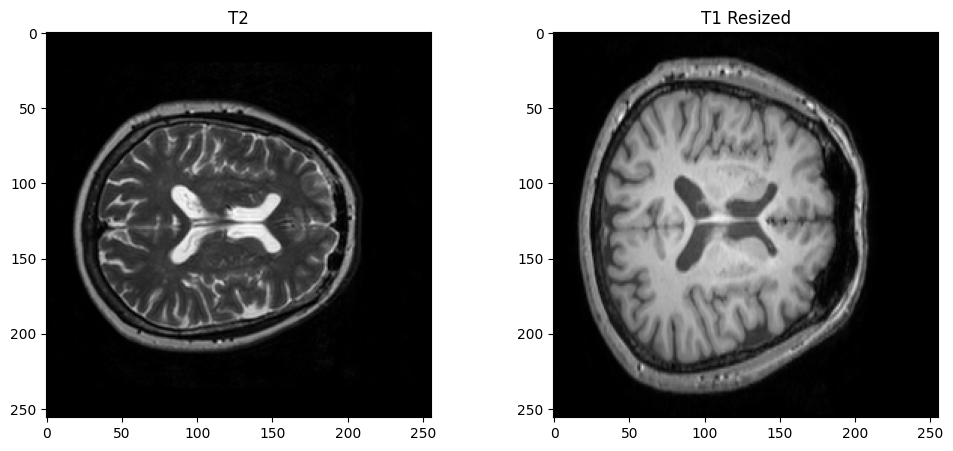

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(t2_slice, cmap='gray')
plt.title('T2')

plt.subplot(1, 2, 2)
plt.imshow(t1_resized, cmap='gray')
plt.title('T1 Resized')
plt.show()

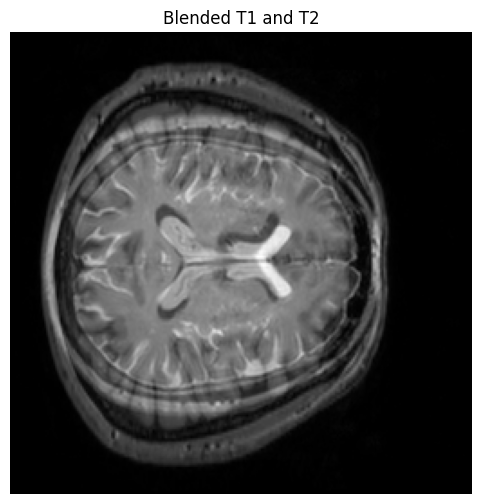

In [ ]:
t2_norm = cv2.normalize(t2_slice, None, 0, 1.0, cv2.NORM_MINMAX)
t1_norm = cv2.normalize(t1_resized, None, 0, 1.0, cv2.NORM_MINMAX)

blended = 0.5 * t2_norm + 0.5 * t1_norm

plt.figure(figsize=(6, 6))
plt.imshow(blended, cmap='gray')
plt.title("Blended T1 and T2")
plt.axis('off')
plt.show()


In [ ]:
def align_t2_to_t1(
    t2_slice,
    t1_slice,
    resize_shape=(256, 256),
    canny_thresh_low=30,
    canny_thresh_high=100,
    nfeatures=1500,
    edgeThreshold=15,
    scaleFactor=1.2,
    lowe_ratio=0.75,
    ransac_thresh=4.0,
    ransac_iters=2000,
    ransac_conf=0.99,
    show_inliers=True,
):
    t1_resized = cv2.resize(t1_slice, resize_shape, interpolation=cv2.INTER_LINEAR)
    t2_uint8 = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t1_uint8 = cv2.normalize(t1_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    t2_edges = cv2.Canny(t2_uint8, canny_thresh_low, canny_thresh_high)
    t1_edges = cv2.Canny(t1_uint8, canny_thresh_low, canny_thresh_high)

    orb = cv2.ORB_create(nfeatures=nfeatures, edgeThreshold=edgeThreshold, scaleFactor=scaleFactor)
    kp1, des1 = orb.detectAndCompute(t2_edges, None)
    kp2, des2 = orb.detectAndCompute(t1_edges, None)

    if des1 is None or des2 is None:
        print("No descriptors found.")
        return None

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < lowe_ratio * n.distance]

    if len(good_matches) < 3:
        print("Not enough good matches.")
        return None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    M, inliers = cv2.estimateAffine2D(
        src_pts, dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh,
        maxIters=ransac_iters,
        confidence=ransac_conf
    )

    if M is None:
        print("Transform estimation failed.")
        return None

    t2_aligned = cv2.warpAffine(t2_uint8, M, resize_shape)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(t2_uint8, cmap='gray')
    plt.title("Original T2")
    plt.subplot(1, 3, 2)
    plt.imshow(t1_uint8, cmap='gray')
    plt.title("Resized T1")
    plt.subplot(1, 3, 3)
    plt.imshow(t2_aligned, cmap='gray')
    plt.title("T2 Aligned to T1")
    plt.tight_layout()
    plt.show()

    img_matches = cv2.drawMatches(t2_edges, kp1, t1_edges, kp2, good_matches[:50], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(16, 8))
    plt.imshow(img_matches)
    plt.title("Top Keypoint Matches")
    plt.axis('off')
    plt.show()

    if show_inliers and inliers is not None:
        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
        img_inliers = cv2.drawMatches(
            t2_edges, kp1, t1_edges, kp2, inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(16, 8))
        plt.imshow(img_inliers)
        plt.title("Inlier Matches")
        plt.axis('off')
        plt.show()

    return {
        "transform": M,
        "t2_aligned": t2_aligned,
        "inliers": inliers,
        "keypoints_t2": kp1,
        "keypoints_t1": kp2,
        "matches": good_matches
    }


In [ ]:
def align_t2_to_t1_sift(
    t2_slice,
    t1_slice,
    resize_shape=(256, 256),
    canny_thresh_low=30,
    canny_thresh_high=100,
    lowe_ratio=0.75,
    ransac_thresh=4.0,
    ransac_iters=2000,
    ransac_conf=0.99,
    show_inliers=True,
):
    t1_resized = cv2.resize(t1_slice, resize_shape, interpolation=cv2.INTER_LINEAR)
    t2_uint8 = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t1_uint8 = cv2.normalize(t1_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    t2_edges = cv2.Canny(t2_uint8, canny_thresh_low, canny_thresh_high)
    t1_edges = cv2.Canny(t1_uint8, canny_thresh_low, canny_thresh_high)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(t2_edges, None)
    kp2, des2 = sift.detectAndCompute(t1_edges, None)

    if des1 is None or des2 is None:
        print("No descriptors found.")
        return None

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < lowe_ratio * n.distance]

    if len(good_matches) < 3:
        print("Not enough good matches.")
        return None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    M, inliers = cv2.estimateAffine2D(
        src_pts, dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh,
        maxIters=ransac_iters,
        confidence=ransac_conf
    )

    if M is None:
        print("Transform estimation failed.")
        return None

    t2_aligned = cv2.warpAffine(t2_uint8, M, resize_shape)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(t2_uint8, cmap='gray')
    plt.title("Original T2")
    plt.subplot(1, 3, 2)
    plt.imshow(t1_uint8, cmap='gray')
    plt.title("Resized T1")
    plt.subplot(1, 3, 3)
    plt.imshow(t2_aligned, cmap='gray')
    plt.title("T2 Aligned to T1")
    plt.tight_layout()
    plt.show()

    img_matches = cv2.drawMatches(t2_edges, kp1, t1_edges, kp2, good_matches[:50], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(16, 8))
    plt.imshow(img_matches)
    plt.title("Top Keypoint Matches (SIFT + FLANN)")
    plt.axis('off')
    plt.show()

    if show_inliers and inliers is not None:
        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
        img_inliers = cv2.drawMatches(
            t2_edges, kp1, t1_edges, kp2, inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(16, 8))
        plt.imshow(img_inliers)
        plt.title("Inlier Matches")
        plt.axis('off')
        plt.show()

    return {
        "transform": M,
        "t2_aligned": t2_aligned,
        "inliers": inliers,
        "keypoints_t2": kp1,
        "keypoints_t1": kp2,
        "matches": good_matches
    }


In [ ]:
result = align_t2_to_t1(t2_slice, t1_slice)

In [ ]:
result = align_t2_to_t1_sift(t2_slice, t1_slice)

In [ ]:
def batch_test_alignment(
    t2_slice,
    t1_slice,
    method='sift',  # 'sift' or 'orb'
    param_grid=None,
    score_fn=lambda res: np.sum(res['inliers']) if res and res['inliers'] is not None else 0
):
    from itertools import product

    if param_grid is None:
        param_grid = {
            'lowe_ratio': [0.7, 0.75, 0.8],
            'ransac_thresh': [2.0, 4.0],
            'canny_thresh_low': [30],
            'canny_thresh_high': [100],
        }

    keys = list(param_grid.keys())
    values = list(param_grid.values())
    best_score = -1
    best_result = None
    best_params = None

    for combo in product(*values):
        params = dict(zip(keys, combo))

        if method == 'orb':
            result = align_t2_to_t1(
                t2_slice, t1_slice,
                lowe_ratio=params.get('lowe_ratio', 0.75),
                ransac_thresh=params.get('ransac_thresh', 4.0),
                canny_thresh_low=params.get('canny_thresh_low', 30),
                canny_thresh_high=params.get('canny_thresh_high', 100),
                show_inliers=False
            )
        elif method == 'sift':
            result = align_t2_to_t1_sift(
                t2_slice, t1_slice,
                lowe_ratio=params.get('lowe_ratio', 0.75),
                ransac_thresh=params.get('ransac_thresh', 4.0),
                canny_thresh_low=params.get('canny_thresh_low', 30),
                canny_thresh_high=params.get('canny_thresh_high', 100),
                show_inliers=False
            )
        else:
            raise ValueError("method must be 'orb' or 'sift'")

        score = score_fn(result)
        print(f"Params: {params} → Score: {score}")

        if score > best_score:
            best_score = score
            best_result = result
            best_params = params

    print(f"\nBest score: {best_score}")
    print(f"Best parameters: {best_params}")

    if best_result:
        best_result['score'] = best_score
        best_result['params'] = best_params

    return best_result


In [ ]:
param_grid = {
    'lowe_ratio': [0.7, 0.75, 0.8],
    'ransac_thresh': [2.0, 4.0, 6.0],
    'canny_thresh_low': [30, 50],
    'canny_thresh_high': [100, 150]
}

best_result = batch_test_alignment(t2_slice, t1_slice, method='sift', param_grid=param_grid)


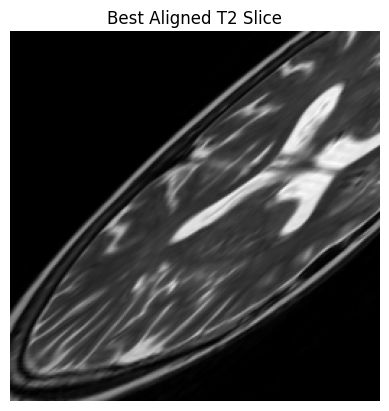

In [ ]:
plt.imshow(best_result['t2_aligned'], cmap='gray')
plt.title("Best Aligned T2 Slice")
plt.axis('off')
plt.show()


In [ ]:
def align_t2_to_t1_sift_rigid(
    t2_slice,
    t1_slice,
    resize_shape=(256, 256),
    lowe_ratio=0.75,
    ransac_thresh=4.0,
    ransac_iters=2000,
    ransac_conf=0.99,
    show_inliers=True,
):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    t1_resized = cv2.resize(t1_slice, resize_shape, interpolation=cv2.INTER_LINEAR)
    t2_resized = cv2.resize(t2_slice, resize_shape, interpolation=cv2.INTER_LINEAR)

    t1_uint8 = cv2.normalize(t1_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t2_uint8 = cv2.normalize(t2_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(t2_uint8, None)
    kp2, des2 = sift.detectAndCompute(t1_uint8, None)

    if des1 is None or des2 is None:
        print("No descriptors found.")
        return None

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < lowe_ratio * n.distance]

    if len(good_matches) < 3:
        print("Not enough good matches.")
        return None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    M, inliers = cv2.estimateAffinePartial2D(
        src_pts, dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh,
        maxIters=ransac_iters,
        confidence=ransac_conf
    )

    if M is None:
        print("Transform estimation failed.")
        return None

    t2_aligned = cv2.warpAffine(t2_uint8, M, resize_shape)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(t2_uint8, cmap='gray')
    plt.title("Original T2")

    plt.subplot(1, 3, 2)
    plt.imshow(t1_uint8, cmap='gray')
    plt.title("Original T1")

    plt.subplot(1, 3, 3)
    plt.imshow(t2_aligned, cmap='gray')
    plt.title("Aligned T2 (Rigid SIFT)")

    plt.tight_layout()
    plt.show()

    img_matches = cv2.drawMatches(t2_uint8, kp1, t1_uint8, kp2, good_matches[:50], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(16, 8))
    plt.imshow(img_matches)
    plt.title("Top Keypoint Matches (SIFT on Raw Images)")
    plt.axis('off')
    plt.show()

    if show_inliers and inliers is not None:
        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
        img_inliers = cv2.drawMatches(
            t2_uint8, kp1, t1_uint8, kp2, inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(16, 8))
        plt.imshow(img_inliers)
        plt.title("Inlier Matches (Rigid Transform)")
        plt.axis('off')
        plt.show()

    return {
        "transform": M,
        "t2_aligned": t2_aligned,
        "inliers": inliers,
        "keypoints_t2": kp1,
        "keypoints_t1": kp2,
        "matches": good_matches
    }


In [ ]:
result = align_t2_to_t1_sift_rigid(t2_slice, t1_slice)


In [ ]:
def sift_roi_registration_enhanced(
    t2_slice,
    t1_slice,
    resize_shape=(256, 256),
    roi_frac=0.8,
    lowe_ratio=0.75,
    ransac_thresh=4.0,
    ransac_iters=2000,
    ransac_conf=0.99,
    show_inliers=True,
):

    t2_resized = cv2.resize(t2_slice, resize_shape, interpolation=cv2.INTER_LINEAR)
    t1_resized = cv2.resize(t1_slice, resize_shape, interpolation=cv2.INTER_LINEAR)

    t2_uint8 = cv2.normalize(t2_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t1_uint8 = cv2.normalize(t1_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    t2_lap = cv2.Laplacian(t2_uint8, cv2.CV_8U)
    t1_lap = cv2.Laplacian(t1_uint8, cv2.CV_8U)

    sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=10)

    def detect_within_roi(img):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        h, w = img.shape
        cx, cy = w // 2, h // 2
        r = int(min(h, w) * roi_frac / 2)

        filtered_kp = []
        filtered_des = []

        for kp, des in zip(keypoints, descriptors):
            x, y = kp.pt
            if (cx - r < x < cx + r) and (cy - r < y < cy + r):
                filtered_kp.append(kp)
                filtered_des.append(des)

        if len(filtered_kp) < 3:
            return [], None
        return filtered_kp, np.stack(filtered_des)

    kp1, des1 = detect_within_roi(t2_lap)
    kp2, des2 = detect_within_roi(t1_lap)

    if des1 is None or des2 is None:
        print("Not enough descriptors in ROI.")
        return None

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < lowe_ratio * n.distance]

    if len(good_matches) < 3:
        print("Not enough good matches.")
        return None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    M, inliers = cv2.estimateAffinePartial2D(
        src_pts, dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh,
        maxIters=ransac_iters,
        confidence=ransac_conf
    )

    if M is None:
        print("Transform estimation failed.")
        return None

    t2_aligned = cv2.warpAffine(t2_uint8, M, resize_shape)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(t2_uint8, cmap='gray')
    plt.title("Original T2")

    plt.subplot(1, 3, 2)
    plt.imshow(t1_uint8, cmap='gray')
    plt.title("Original T1")

    plt.subplot(1, 3, 3)
    plt.imshow(t2_aligned, cmap='gray')
    plt.title("Aligned T2 (Laplacian + ROI-SIFT)")
    plt.tight_layout()
    plt.show()

    if show_inliers and inliers is not None:
        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
        img_inliers = cv2.drawMatches(
            t2_uint8, kp1, t1_uint8, kp2, inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(16, 8))
        plt.imshow(img_inliers)
        plt.title("Inlier Matches (Laplacian ROI-SIFT)")
        plt.axis('off')
        plt.show()

    return {
        "transform": M,
        "t2_aligned": t2_aligned,
        "inliers": inliers,
        "keypoints_t2": kp1,
        "keypoints_t1": kp2,
        "matches": good_matches
    }


In [ ]:
result = sift_roi_registration_enhanced(t2_slice, t1_slice, roi_frac=0.8)

Not enough good matches.


In [ ]:
def batch_test_alignment(
    t2_slice,
    t1_slice,
    method='sift',  # 'sift' or 'orb'
    param_grid=None,
    score_fn=lambda res: np.sum(res['inliers']) if res and res['inliers'] is not None else 0
):
    from itertools import product

    if param_grid is None:
        param_grid = {
            'lowe_ratio': [0.7, 0.75, 0.8],
            'ransac_thresh': [2.0, 4.0],
            'canny_thresh_low': [30],
            'canny_thresh_high': [100],
        }

    keys = list(param_grid.keys())
    values = list(param_grid.values())
    best_score = -1
    best_result = None
    best_params = None

    for combo in product(*values):
        params = dict(zip(keys, combo))

        if method == 'orb':
            result = align_t2_to_t1(
                t2_slice, t1_slice,
                lowe_ratio=params.get('lowe_ratio', 0.75),
                ransac_thresh=params.get('ransac_thresh', 4.0),
                canny_thresh_low=params.get('canny_thresh_low', 30),
                canny_thresh_high=params.get('canny_thresh_high', 100),
                show_inliers=False
            )
        elif method == 'sift':
            result = align_t2_to_t1_sift(
                t2_slice, t1_slice,
                lowe_ratio=params.get('lowe_ratio', 0.75),
                ransac_thresh=params.get('ransac_thresh', 4.0),
                canny_thresh_low=params.get('canny_thresh_low', 30),
                canny_thresh_high=params.get('canny_thresh_high', 100),
                show_inliers=False
            )
        else:
            raise ValueError("method must be 'orb' or 'sift'")

        score = score_fn(result)
        print(f"Params: {params} → Score: {score}")

        if score > best_score:
            best_score = score
            best_result = result
            best_params = params

    print(f"\nBest score: {best_score}")
    print(f"Best parameters: {best_params}")

    if best_result:
        best_result['score'] = best_score
        best_result['params'] = best_params

    return best_result


In [ ]:
param_grid = {
    'lowe_ratio': [0.7, 0.75, 0.8],
    'ransac_thresh': [2.0, 4.0, 6.0],
    'canny_thresh_low': [30, 50],
    'canny_thresh_high': [100, 150]
}

best_result = batch_test_alignment(t2_slice, t1_slice, method='sift', param_grid=param_grid)


In [ ]:
def align_t2_to_t1_sift_with_spatial_filtering(
    t2_slice,
    t1_slice,
    resize_shape=(256, 256),
    lowe_ratio=0.75,
    ransac_thresh=4.0,
    ransac_iters=2000,
    ransac_conf=0.99,
    canny_thresh_low=30,
    canny_thresh_high=100,
    spatial_filter=True,
    max_y_diff=40,
    max_x_diff=100,
    show_inliers=True,
):

    t2_resized = cv2.resize(t2_slice, resize_shape)
    t1_resized = cv2.resize(t1_slice, resize_shape)

    t2_uint8 = cv2.normalize(t2_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t1_uint8 = cv2.normalize(t1_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    t2_edges = cv2.Canny(t2_uint8, canny_thresh_low, canny_thresh_high)
    t1_edges = cv2.Canny(t1_uint8, canny_thresh_low, canny_thresh_high)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(t2_edges, None)
    kp2, des2 = sift.detectAndCompute(t1_edges, None)

    if des1 is None or des2 is None:
        print("No descriptors found.")
        return None

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if True:
            good_matches.append(m)

    if spatial_filter:
        filtered_matches = []
        for m in good_matches:
            pt1 = kp1[m.queryIdx].pt
            pt2 = kp2[m.trainIdx].pt
            if abs(pt1[1] - pt2[1]) < max_y_diff and abs(pt1[0] - pt2[0]) < max_x_diff:
                filtered_matches.append(m)
        good_matches = filtered_matches

    if len(good_matches) < 3:
        print("Not enough good matches.")
        return None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    M, inliers = cv2.estimateAffinePartial2D(
        src_pts, dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh,
        maxIters=ransac_iters,
        confidence=ransac_conf
    )

    if M is None:
        print("Transform estimation failed.")
        return None

    t2_aligned = cv2.warpAffine(t2_uint8, M, resize_shape)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(t2_uint8, cmap='gray')
    plt.title("Original T2")
    plt.subplot(1, 3, 2)
    plt.imshow(t1_uint8, cmap='gray')
    plt.title("Original T1")
    plt.subplot(1, 3, 3)
    plt.imshow(t2_aligned, cmap='gray')
    plt.title("Aligned T2")
    plt.tight_layout()
    plt.show()

    if show_inliers and inliers is not None:
        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
        img_inliers = cv2.drawMatches(
            t2_uint8, kp1, t1_uint8, kp2, inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(16, 8))
        plt.imshow(img_inliers)
        plt.title("Inlier Matches (Spatially Filtered)")
        plt.axis('off')
        plt.show()

    return {
        "transform": M,
        "t2_aligned": t2_aligned,
        "inliers": inliers,
        "keypoints_t2": kp1,
        "keypoints_t1": kp2,
        "matches": good_matches
    }


In [ ]:
result = align_t2_to_t1_sift_with_spatial_filtering(
    t2_slice, t1_slice,
    lowe_ratio=0.8,
    spatial_filter=True,
    max_y_diff=50,
    max_x_diff=80
)


In [ ]:
def batch_test_alignment(
    t2_slice,
    t1_slice,
    method='sift',
    param_grid=None,
    score_fn=lambda res: np.sum(res['inliers']) if res and res['inliers'] is not None else 0
):
    from itertools import product

    if param_grid is None:
        param_grid = {
            'lowe_ratio': [0.75, 0.8],
            'ransac_thresh': [2.0, 4.0],
            'canny_thresh_low': [10, 30],
            'canny_thresh_high': [100, 150],
            'max_y_diff': [30, 50],
            'max_x_diff': [80, 120],
        }

    keys = list(param_grid.keys())
    values = list(param_grid.values())
    best_score = -1
    best_result = None
    best_params = None

    from tqdm import tqdm
    for combo in tqdm(list(product(*values)), desc="Testing parameter combinations"):
        params = dict(zip(keys, combo))

        if method == 'sift':
            result = align_t2_to_t1_sift_with_spatial_filtering(
                t2_slice=t2_slice,
                t1_slice=t1_slice,
                lowe_ratio=params.get('lowe_ratio', 0.75),
                ransac_thresh=params.get('ransac_thresh', 4.0),
                canny_thresh_low=params.get('canny_thresh_low', 30),
                canny_thresh_high=params.get('canny_thresh_high', 100),
                max_y_diff=params.get('max_y_diff', 40),
                max_x_diff=params.get('max_x_diff', 100),
                spatial_filter=True,
                show_inliers=False
            )
        else:
            raise ValueError("Only 'sift' method is supported in this batch version.")

        score = score_fn(result)
        print(f"Params: {params} → Score: {score}")

        if score > best_score:
            best_score = score
            best_result = result
            best_params = params

    print(f"\n Best score: {best_score}")
    print(f"Best parameters: {best_params}")

    if best_result:
        best_result['score'] = best_score
        best_result['params'] = best_params

    return best_result


In [ ]:
param_grid = {
    'lowe_ratio': [0.75, 0.8, 0.85],
    'ransac_thresh': [2.0, 4.0],
    'canny_thresh_low': [10, 30],
    'canny_thresh_high': [100, 150],
    'max_y_diff': [30, 50],
    'max_x_diff': [80, 120],
}


In [ ]:
best_result = batch_test_alignment(t2_slice, t1_slice, method='sift', param_grid=param_grid)

plt.imshow(best_result['t2_aligned'], cmap='gray')
plt.title("Best Aligned T2 Slice")
plt.axis('off')
plt.show()


In [ ]:
def align_t2_to_t1_sift_with_spatial_filtering(
    t2_slice,
    t1_slice,
    resize_shape=(256, 256),
    lowe_ratio=0.75,
    ransac_thresh=4.0,
    ransac_iters=2000,
    ransac_conf=0.99,
    canny_thresh_low=30,
    canny_thresh_high=100,
    spatial_filter=True,
    max_y_diff=40,
    max_x_diff=100,
    show_inliers=True,
    show_blend=True,
):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    t2_resized = cv2.resize(t2_slice, resize_shape)
    t1_resized = cv2.resize(t1_slice, resize_shape)

    t2_uint8 = cv2.normalize(t2_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t1_uint8 = cv2.normalize(t1_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    t2_edges = cv2.Canny(t2_uint8, canny_thresh_low, canny_thresh_high)
    t1_edges = cv2.Canny(t1_uint8, canny_thresh_low, canny_thresh_high)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(t2_edges, None)
    kp2, des2 = sift.detectAndCompute(t1_edges, None)

    if des1 is None or des2 is None:
        print("No descriptors found.")
        return None

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        # if m.distance < lowe_ratio * n.distance:
        if True:
            good_matches.append(m)

    if spatial_filter:
        filtered_matches = []
        for m in good_matches:
            pt1 = kp1[m.queryIdx].pt
            pt2 = kp2[m.trainIdx].pt
            if abs(pt1[1] - pt2[1]) < max_y_diff and abs(pt1[0] - pt2[0]) < max_x_diff:
                filtered_matches.append(m)
        good_matches = filtered_matches

    if len(good_matches) < 3:
        print("Not enough good matches.")
        return None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    M, inliers = cv2.estimateAffinePartial2D(
        src_pts, dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh,
        maxIters=ransac_iters,
        confidence=ransac_conf
    )

    if M is None:
        print("Transform estimation failed.")
        return None

    t2_aligned = cv2.warpAffine(t2_uint8, M, resize_shape)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(t2_uint8, cmap='gray')
    plt.title("Original T2")
    plt.subplot(1, 3, 2)
    plt.imshow(t1_uint8, cmap='gray')
    plt.title("Original T1")
    plt.subplot(1, 3, 3)
    plt.imshow(t2_aligned, cmap='gray')
    plt.title("Aligned T2")
    plt.tight_layout()
    plt.show()

    if show_inliers and inliers is not None:
        inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
        img_inliers = cv2.drawMatches(
            t2_uint8, kp1, t1_uint8, kp2, inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(16, 8))
        plt.imshow(img_inliers)
        plt.title("Inlier Matches (Spatially Filtered)")
        plt.axis('off')
        plt.show()

    if show_blend:
        t2_norm = t2_aligned.astype(np.float32) / 255.0
        t1_norm = t1_uint8.astype(np.float32) / 255.0
        blended = 0.5 * t2_norm + 0.5 * t1_norm
        plt.figure(figsize=(6, 6))
        plt.imshow(blended, cmap='gray')
        plt.title("Blended T1 + Aligned T2")
        plt.axis('off')
        plt.show()

    return {
        "transform": M,
        "t2_aligned": t2_aligned,
        "inliers": inliers,
        "keypoints_t2": kp1,
        "keypoints_t1": kp2,
        "matches": good_matches
    }


In [ ]:
result = align_t2_to_t1_sift_with_spatial_filtering(t2_slice, t1_slice, show_blend=True)


In [ ]:
def batch_test_alignment(
    t2_slice,
    t1_slice,
    method='sift',
    param_grid=None,
    score_fn=lambda res: np.sum(res['inliers']) if res and res['inliers'] is not None else 0,
    show_blend_final=True,
):
    from itertools import product
    from tqdm import tqdm

    if param_grid is None:
        param_grid = {
          'lowe_ratio': [0.7, 0.8, 0.85, 0.9],
          'ransac_thresh': [1.0, 2.0, 4.0, 6.0, 8.0],
          'canny_thresh_low': [5, 10, 20, 25],
          'canny_thresh_high': [60, 80, 100, 120, 140],
          'max_y_diff': [40],
          'max_x_diff': [100],
        }


    keys = list(param_grid.keys())
    values = list(param_grid.values())
    best_score = -1
    best_result = None
    best_params = None

    for combo in tqdm(list(product(*values)), desc="Testing parameter combinations"):
        params = dict(zip(keys, combo))

        if method == 'sift':
            result = align_t2_to_t1_sift_with_spatial_filtering(
                t2_slice=t2_slice,
                t1_slice=t1_slice,
                lowe_ratio=params.get('lowe_ratio', 0.75),
                ransac_thresh=params.get('ransac_thresh', 4.0),
                canny_thresh_low=params.get('canny_thresh_low', 30),
                canny_thresh_high=params.get('canny_thresh_high', 100),
                max_y_diff=params.get('max_y_diff', 40),
                max_x_diff=params.get('max_x_diff', 100),
                spatial_filter=True,
                show_inliers=True,
                show_blend=True
            )
        else:
            raise ValueError("Only 'sift' method is supported in this batch version.")

        score = score_fn(result)
        print(f"Params: {params} → Score: {score}")

        if score > best_score:
            best_score = score
            best_result = result
            best_params = params

    print(f"\nBest score: {best_score}")
    print(f"Best parameters: {best_params}")

    if best_result:
        best_result = align_t2_to_t1_sift_with_spatial_filtering(
            t2_slice=t2_slice,
            t1_slice=t1_slice,
            lowe_ratio=best_params.get('lowe_ratio', 0.75),
            ransac_thresh=best_params.get('ransac_thresh', 4.0),
            canny_thresh_low=best_params.get('canny_thresh_low', 30),
            canny_thresh_high=best_params.get('canny_thresh_high', 100),
            max_y_diff=best_params.get('max_y_diff', 40),
            max_x_diff=best_params.get('max_x_diff', 100),
            spatial_filter=True,
            show_inliers=True,
            show_blend=show_blend_final
        )
        best_result['score'] = best_score
        best_result['params'] = best_params

    return best_result


In [ ]:
best_result = batch_test_alignment(
    t2_slice, t1_slice,
    param_grid=param_grid,
    show_blend_final=True
)

# LOFTR results

mkpts1 shape: (505, 2)
mkpts2 shape: (505, 2)


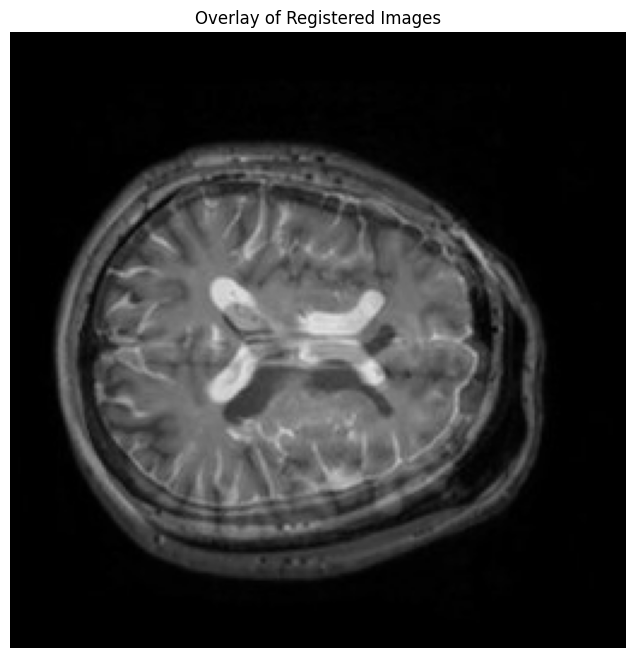

In [ ]:
image1 = cv2.imread('/content/drive/MyDrive/BIOE484FP/t1_resized.jpg')
image2 = cv2.imread('/content/drive/MyDrive/BIOE484FP/t2_slice.jpg')

data = np.load('/content/drive/MyDrive/BIOE484FP/loftr_matches_keypoints2.npz')
mkpts1 = data["mkpts0"]
mkpts2 = data["mkpts1"]

print("mkpts1 shape:", mkpts1.shape)
print("mkpts2 shape:", mkpts2.shape)

points_1 = mkpts1.reshape(-1, 1, 2)
points_2 = mkpts2.reshape(-1, 1, 2)

H, _ = cv2.findHomography(points_1, points_2, cv2.RANSAC, 5.0)

aligned_image = cv2.warpPerspective(image1, H, (image2.shape[1], image2.shape[0]))

result = cv2.addWeighted(image2, 0.5, aligned_image, 0.5, 0)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Overlay of Registered Images")
plt.show()

# VGG features

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess(img, resize=(224, 224)):
    img = cv2.resize(img, resize).astype(np.float32)
    img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
    img_rgb = np.stack([img]*3, axis=0)  # replicate to 3 channels
    return torch.tensor(img_rgb).unsqueeze(0)  # [1, 3, H, W]

def extract_features(img_tensor, model, layer='features.16'):
    with torch.no_grad():
        for name, module in model.features._modules.items():
            img_tensor = module(img_tensor)
            if name == layer.split('.')[-1]:
                break
    return img_tensor.squeeze(0)  # shape: [C, H, W]

def cosine_similarity_map(f1, f2):
    f1 = F.normalize(f1, dim=0)
    f2 = F.normalize(f2, dim=0)
    sim = (f1 * f2).sum(dim=0)
    return sim.cpu().numpy()

def dense_feature_match_vgg(t1_slice, t2_slice):
    vgg = models.vgg16(pretrained=True).eval()

    t1_tensor = preprocess(t1_slice)
    t2_tensor = preprocess(t2_slice)

    f_t1 = extract_features(t1_tensor, vgg)  # [C, H, W]
    f_t2 = extract_features(t2_tensor, vgg)

    sim_map = cosine_similarity_map(f_t1, f_t2)

    plt.figure(figsize=(6, 6))
    plt.imshow(sim_map, cmap='jet')
    plt.title("Cosine Similarity: T1 vs T2 Features")
    plt.axis('off')
    plt.colorbar()
    plt.show()

    return sim_map


In [ ]:
dense_feature_match_vgg(t1_slice, t2_resized)


NameError: name 't2_resized' is not defined

In [ ]:
def blend_by_similarity_mask(t1_slice, t2_slice, sim_map, threshold=0.5):
    mask = (sim_map > threshold).astype(np.float32)

    mask_resized = cv2.resize(mask, t1_slice.shape[::-1])

    t1_norm = cv2.normalize(t1_slice, None, 0, 1, cv2.NORM_MINMAX)
    t2_norm = cv2.normalize(t2_slice, None, 0, 1, cv2.NORM_MINMAX)

    blend = mask_resized * t1_norm + (1 - mask_resized) * t2_norm

    plt.figure(figsize=(6, 6))
    plt.imshow(blend, cmap='gray')
    plt.title("Blended T1 + T2 (Similarity Masked)")
    plt.axis('off')
    plt.show()

    return blend


In [ ]:
def soft_blend_by_similarity(t1_slice, t2_slice, sim_map):
    sim_resized = cv2.resize(sim_map, t1_slice.shape[::-1])
    sim_norm = cv2.normalize(sim_resized, None, 0, 1, cv2.NORM_MINMAX)

    t1_norm = cv2.normalize(t1_slice, None, 0, 1, cv2.NORM_MINMAX)
    t2_norm = cv2.normalize(t2_slice, None, 0, 1, cv2.NORM_MINMAX)

    blend = sim_norm * t1_norm + (1 - sim_norm) * t2_norm

    plt.figure(figsize=(6, 6))
    plt.imshow(blend, cmap='gray')
    plt.title("Soft Blended T1 + T2 (Feature Weighted)")
    plt.axis('off')
    plt.show()

    return blend


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


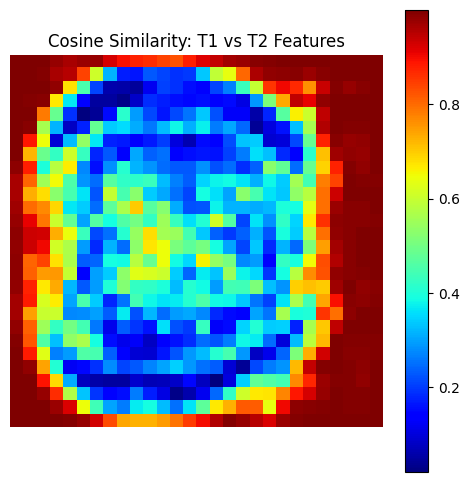

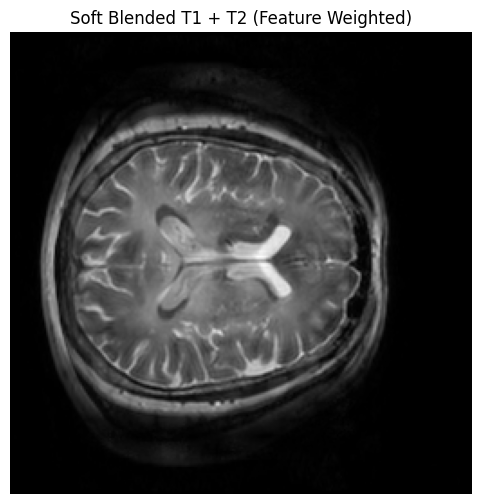

In [ ]:
sim_map = dense_feature_match_vgg(t1_resized, t2_slice)
blended = soft_blend_by_similarity(t1_resized, t2_slice, sim_map)
